<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Search-trajectory-files-and-create-output-path" data-toc-modified-id="Search-trajectory-files-and-create-output-path-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Search trajectory files and create output path</a></span></li><li><span><a href="#Plot-experiment-trajectories" data-toc-modified-id="Plot-experiment-trajectories-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Plot experiment trajectories</a></span></li><li><span><a href="#Processing-Experiments" data-toc-modified-id="Processing-Experiments-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Processing Experiments</a></span></li><li><span><a href="#Interactive-plot-of-density-images" data-toc-modified-id="Interactive-plot-of-density-images-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Interactive plot of density images</a></span></li><li><span><a href="#Aggregate-unfiltered-density-distributions" data-toc-modified-id="Aggregate-unfiltered-density-distributions-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Aggregate unfiltered density distributions</a></span></li><li><span><a href="#Filter-duplicated-images" data-toc-modified-id="Filter-duplicated-images-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Filter duplicated images</a></span></li><li><span><a href="#Combine-images" data-toc-modified-id="Combine-images-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Combine images</a></span></li><li><span><a href="#Aggregate-filtered-density-distributions" data-toc-modified-id="Aggregate-filtered-density-distributions-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Aggregate filtered density distributions</a></span></li><li><span><a href="#Filter-50/50-distributions" data-toc-modified-id="Filter-50/50-distributions-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Filter 50/50 distributions</a></span></li><li><span><a href="#Plot-density-maps-to-file" data-toc-modified-id="Plot-density-maps-to-file-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Plot density maps to file</a></span></li></ul></div>

In [1]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as matplot
import itertools
import math
import sys

from tqdm import tqdm_notebook, tqdm
from os import listdir, mkdir
from os.path import join, isdir
from ipywidgets import *
from multiprocessing import Pool, Lock

module_path = os.path.abspath(os.path.join('../python/python_src_preprocessing/src'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from utils.reader import get_all_trajectory_files, read_trajectory_file

%load_ext autoreload
%autoreload 1
%aimport preprocessing, plotting

%matplotlib inline

# Search trajectory files and create output path

In [2]:
# paramter
input_path = 'check/outputs/obstacle'
output_path = 'check/csvs/obstacle'
experiments = get_all_trajectory_files(input_path)

if not isdir(output_path):
    mkdir(output_path)

# Plot experiment trajectories

In [3]:
# helper functions

def toInch(pixel, dpi=92):
    return pixel / dpi


def plot_experiment(frame, ax):
    # map p-ids to targets
    for pId, group in frame.groupby('pedestrianId'):
        data = group.loc[(group['x'] > 14.5) & (
            group['x'] < 24.9) & (group['y'] < 8.7)]
        ax.plot(data['x'], data['y'], zorder=1)

    rect = matplot.Rectangle(
        (18.49, 6.69), 2.4, 1, edgecolor='r', alpha=1, fill=False, zorder=2, linewidth=2)

    ax.add_patch(rect)
    ax.grid()
    
def common_start(sa, sb):
    """ returns the longest common substring from the beginning of sa and sb 
    taken from https://stackoverflow.com/questions/18715688/find-common-substring-between-two-strings
    """
    def _iter():
        for a, b in zip(sa, sb):
            if a == b:
                yield a
            else:
                return

    return ''.join(_iter())

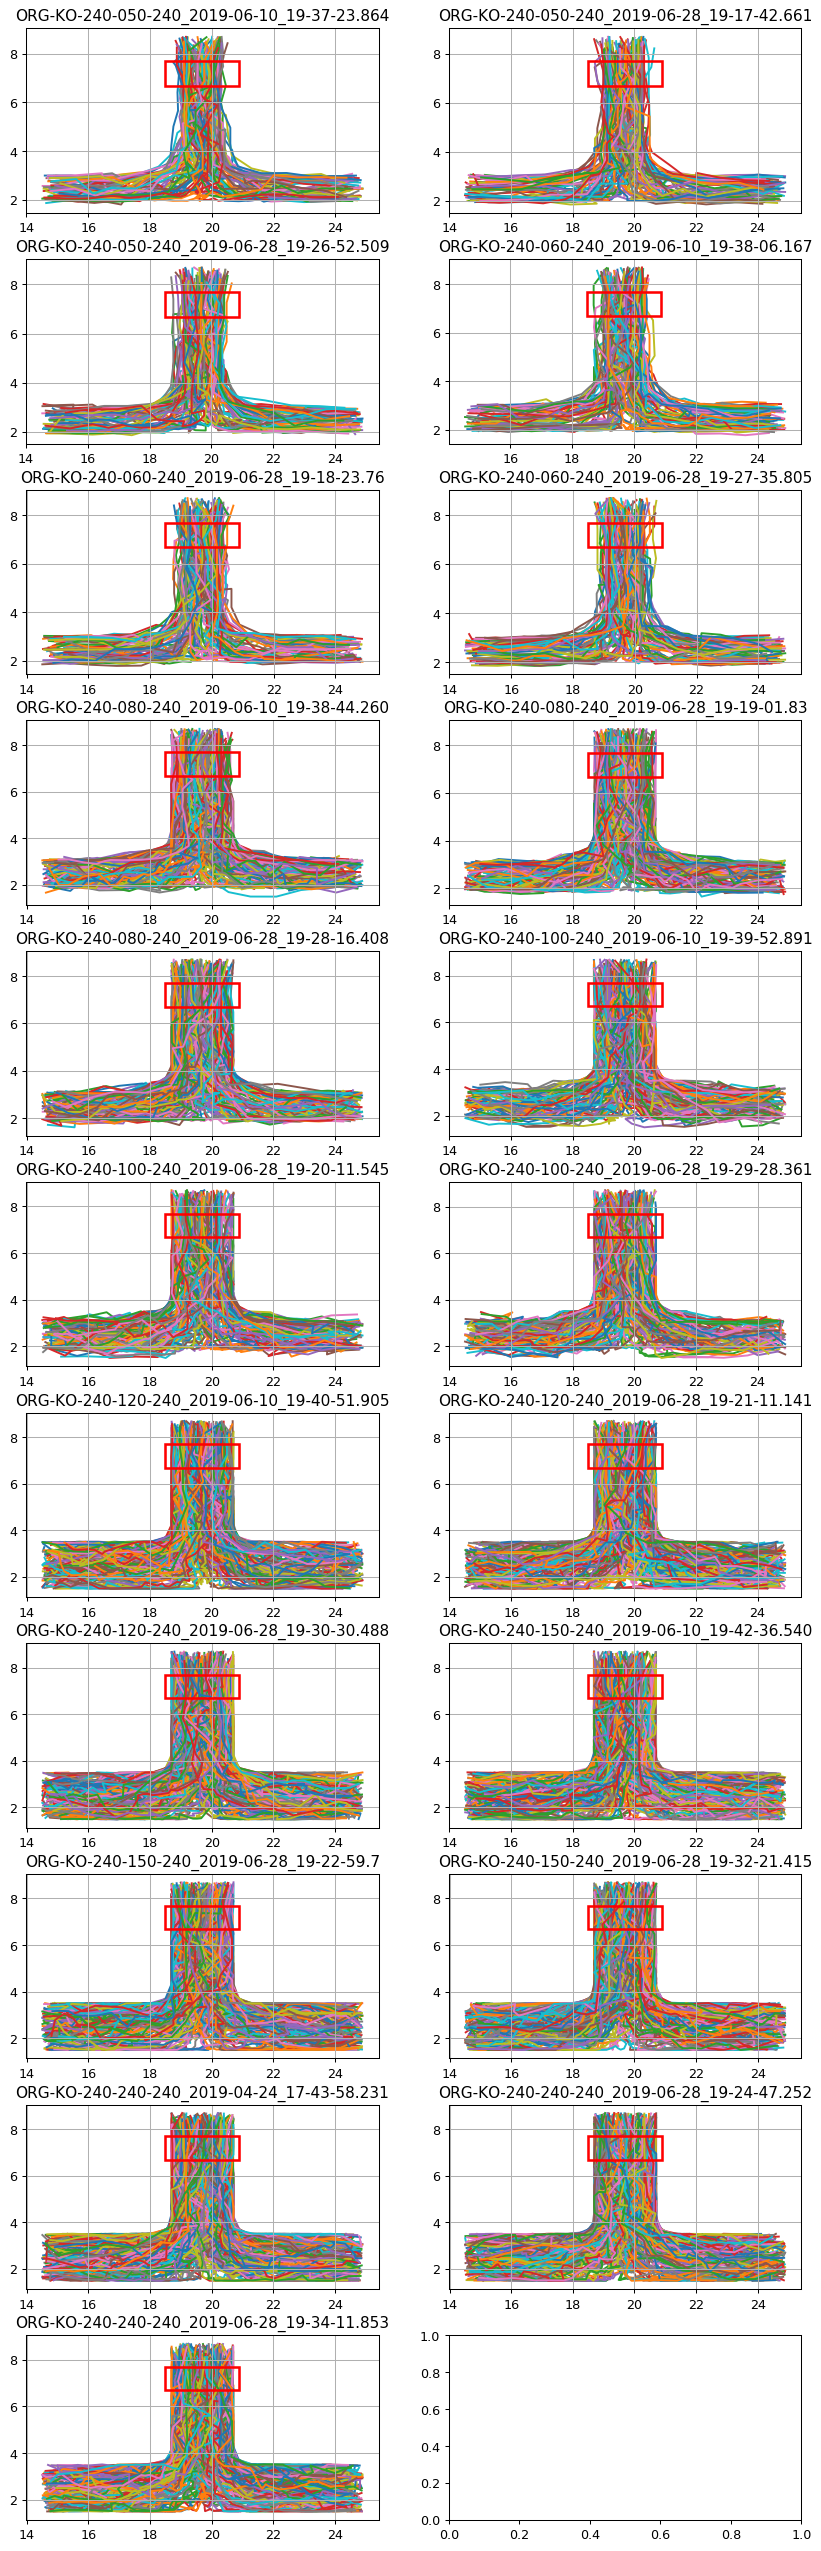

In [4]:
# plot all scenario trajectories to file
# %%capture
plots = len(experiments)
rows = math.ceil(plots / 2.0)
fig, ax = matplot.subplots(nrows=rows, ncols=2, figsize=(
    toInch(1000), toInch(rows * 300)), dpi=92)

ax = np.array(ax).flatten()

for idx in range(plots):
    experiment = experiments[idx]
    directory = os.path.dirname(experiment)
    name = os.path.basename(directory) #.split('_')[0]

    ax[idx].set_title(name)

    frame = read_trajectory_file(experiment)
    plot_experiment(frame, ax[idx])

fig.subplots_adjust(hspace=0.25)
fig.savefig('vadere-scenario-trajectories.pdf', transparent=True)

# Processing Experiments

In [22]:
# processing experiments

results = []
for experiment in tqdm_notebook(experiments, desc='process files'):
    directory = os.path.dirname(experiment)
    name = os.path.basename(directory)

    if os.path.exists(join(output_path, name + '.csv')):
        print('skipping', name)
        continue

    frame = read_trajectory_file(experiment)
    pId2Target = {r['pedestrianId']: r['sourceId'] for i, r in pd.read_csv(
        join(directory, 'sources.csv'), sep=' ', skiprows=1, header=None, names=['pedestrianId', 'sourceId']).iterrows()}
    context = dict({
        'name': name,
        'targets': [0, 1, 2],
        'area':  [18.50, 6.7, 2.4, 1],
        'exact': True,
        'sigma': 0.7,
        'resolution': 0.1,
        'pedestrian_radius': 0.195,
        'gauss_bounds': 2,
        'pId2Target': pId2Target,
        'processors': [
            preprocessing.process_densities,
            preprocessing.process_pedestrians,
            preprocessing.process_percentiles
        ],
        'number_of_cores': 5,
        'skip': 1
    })
    context = preprocessing.process_experiment(frame, context)
    results.append(context)

    densities = np.array(context.get('densities'))
    # sort by timestep number
    densities = densities[densities[:,0].argsort()]
    with open(join(output_path, name + '.csv'), mode='w') as file:
        for density in densities:
            file.write(
                ';'.join(map(lambda r: "{:.10f}".format(r), density[1:])) + '\n')

        file.flush()

using every  1 timestep, # of used timesteps 717 , # of total timesteps 717


100%|████████████████████████████████████████████████████████████████████████████████| 717/717 [00:29<00:00, 23.94it/s]


using every  1 timestep, # of used timesteps 703 , # of total timesteps 703


100%|████████████████████████████████████████████████████████████████████████████████| 703/703 [00:28<00:00, 24.67it/s]


using every  1 timestep, # of used timesteps 705 , # of total timesteps 705


100%|████████████████████████████████████████████████████████████████████████████████| 705/705 [00:28<00:00, 12.65it/s]


using every  1 timestep, # of used timesteps 666 , # of total timesteps 666


100%|████████████████████████████████████████████████████████████████████████████████| 666/666 [00:25<00:00, 11.64it/s]


using every  1 timestep, # of used timesteps 673 , # of total timesteps 673


100%|████████████████████████████████████████████████████████████████████████████████| 673/673 [00:25<00:00, 26.01it/s]


using every  1 timestep, # of used timesteps 688 , # of total timesteps 688


100%|████████████████████████████████████████████████████████████████████████████████| 688/688 [00:29<00:00, 23.49it/s]


using every  1 timestep, # of used timesteps 887 , # of total timesteps 887


100%|████████████████████████████████████████████████████████████████████████████████| 887/887 [00:50<00:00,  7.97it/s]


using every  1 timestep, # of used timesteps 862 , # of total timesteps 862


100%|████████████████████████████████████████████████████████████████████████████████| 862/862 [00:49<00:00,  8.98it/s]


using every  1 timestep, # of used timesteps 873 , # of total timesteps 873


100%|████████████████████████████████████████████████████████████████████████████████| 873/873 [00:49<00:00,  7.80it/s]


using every  1 timestep, # of used timesteps 778 , # of total timesteps 778


100%|████████████████████████████████████████████████████████████████████████████████| 778/778 [00:37<00:00,  7.08it/s]


using every  1 timestep, # of used timesteps 768 , # of total timesteps 768


100%|████████████████████████████████████████████████████████████████████████████████| 768/768 [00:36<00:00, 21.12it/s]


using every  1 timestep, # of used timesteps 779 , # of total timesteps 779


100%|████████████████████████████████████████████████████████████████████████████████| 779/779 [00:36<00:00,  9.32it/s]


using every  1 timestep, # of used timesteps 983 , # of total timesteps 983


100%|████████████████████████████████████████████████████████████████████████████████| 983/983 [01:05<00:00,  8.46it/s]


using every  1 timestep, # of used timesteps 981 , # of total timesteps 981


100%|████████████████████████████████████████████████████████████████████████████████| 981/981 [01:05<00:00,  8.02it/s]


using every  1 timestep, # of used timesteps 957 , # of total timesteps 957


100%|████████████████████████████████████████████████████████████████████████████████| 957/957 [01:02<00:00,  5.65it/s]


using every  1 timestep, # of used timesteps 958 , # of total timesteps 958


100%|████████████████████████████████████████████████████████████████████████████████| 958/958 [01:02<00:00,  7.54it/s]


using every  1 timestep, # of used timesteps 948 , # of total timesteps 948


100%|████████████████████████████████████████████████████████████████████████████████| 948/948 [01:00<00:00, 15.72it/s]


using every  1 timestep, # of used timesteps 960 , # of total timesteps 960


100%|████████████████████████████████████████████████████████████████████████████████| 960/960 [01:02<00:00, 15.33it/s]


using every  1 timestep, # of used timesteps 947 , # of total timesteps 947


100%|████████████████████████████████████████████████████████████████████████████████| 947/947 [01:02<00:00,  6.53it/s]


using every  1 timestep, # of used timesteps 946 , # of total timesteps 946


100%|████████████████████████████████████████████████████████████████████████████████| 946/946 [01:01<00:00,  7.86it/s]


using every  1 timestep, # of used timesteps 919 , # of total timesteps 919


100%|████████████████████████████████████████████████████████████████████████████████| 919/919 [00:58<00:00, 15.75it/s]


# Interactive plot of density images
<font color='red' size='5'><b>Important note:</b><br/>This requires that the result of the processed files (cell above) is still available</font>

In [ ]:
# interactive density maps
%matplotlib notebook

def extrac_xy(pedestrians, x0, y0, resolution):
    x = []
    y = []

    for _, ped in pedestrians.iterrows():
        x.append(int(abs(ped['x'] - x0) * (1 / resolution)))
        y.append(int(abs(ped['y'] - y0) * (1 / resolution)))

    return x, y

for result in results:
    name = result.get('name')
    densities = result.get('densities')
    area = result.get('area')
    peds = result.get('pedestrians')
    size = result.get('size')
    res = result.get('resolution')
    t = len(result.get('targets'))

    start = 0

    first = densities[start][:-t].reshape(size)

    fig, ax = matplot.subplots()

    cbar = None

    ax.set_xticks(np.linspace(0, len(first[0]) - 1, 13))
    ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2,
                        1.4, 1.6, 1.8, 2.0, 2.2, 2.4])

    ax.set_yticks(np.linspace(0, len(first) - 1, 6))
    ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0])

    def update(frame):
        global cbar
        f = densities[frame][:-t].reshape(size)

        ax.clear()
        if cbar is not None:
            cbar.remove()

        img = ax.imshow(f, interpolation='Nearest')
        cbar = fig.colorbar(img)

        x, y = extrac_xy(peds[frame], area[0], area[1], res)

        ax.plot(x, y, '.r', markersize=10)

        ax.set_xticks(np.linspace(0, len(first[0]) - 1, 13))
        ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0,
                            1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4])

        ax.set_yticks(np.linspace(0, len(first) - 1, 6))
        ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0])

    interact(update, frame=widgets.IntSlider(
        min=0, max=len(densities)-1, step=1, value=start))

    break

# Aggregate unfiltered density distributions

In [28]:
# aggregate distributions

# output_p = 'juelich-vadere/output_01_save/'
outputs = list(filter(lambda o: os.path.isfile(os.path.join(output_path, o)) and 'filtered' not in o, os.listdir(output_path)))
dfs = []
for output in outputs:
    dfs.append(pd.read_csv(os.path.join(
        output_path, output), sep=';', header=None))

frame = pd.concat([df.iloc[:, -3:] for df in dfs], sort=False)
print(frame.shape)
display(frame.groupby([230, 231, 232], as_index=False).size().to_frame(
    'frames').reset_index())

(14714, 3)


,230,231,232,frames
0,0.0,0.000000,1.000000,1180
1,0.0,0.125000,0.875000,3
2,0.0,0.142857,0.857143,10
3,0.0,0.166667,0.833333,112
4,0.0,0.200000,0.800000,399
5,0.0,0.222222,0.777778,2
6,0.0,0.250000,0.750000,794
7,0.0,0.285714,0.714286,107
8,0.0,0.333333,0.666667,1592
9,0.0,0.375000,0.625000,41


# Filter duplicated images

In [24]:
# filter consecutive duplicates

outputs = list(filter(lambda o: os.path.isfile(os.path.join(output_path, o)) and 'filtered' not in o, os.listdir(output_path)))

for output in tqdm_notebook(outputs, desc="filter density maps"):
    last = None
    skipped = 0
    written = 0
    with open(os.path.join(output_path, output), "r") as full:
        with open(os.path.join(output_path, output[:-4] + '_filtered.csv'), "w") as filtered:
            for line in full:
                if line != last:
                    filtered.write(line)
                    last = line
                    written = written + 1
                    continue

                skipped = skipped + 1
    print(output, written, 'lines written,', skipped, 'lines skipped')

ORG-KO-240-050-240_2019-06-10_19-37-23.864.csv 247 lines written, 326 lines skipped
ORG-KO-240-050-240_2019-06-28_19-17-42.661.csv 244 lines written, 310 lines skipped
ORG-KO-240-050-240_2019-06-28_19-26-52.509.csv 256 lines written, 299 lines skipped
ORG-KO-240-060-240_2019-06-10_19-38-06.167.csv 229 lines written, 292 lines skipped
ORG-KO-240-060-240_2019-06-28_19-18-23.76.csv 227 lines written, 295 lines skipped
ORG-KO-240-060-240_2019-06-28_19-27-35.805.csv 229 lines written, 319 lines skipped
ORG-KO-240-080-240_2019-06-10_19-38-44.260.csv 385 lines written, 357 lines skipped
ORG-KO-240-080-240_2019-06-28_19-19-01.83.csv 385 lines written, 343 lines skipped
ORG-KO-240-080-240_2019-06-28_19-28-16.408.csv 366 lines written, 359 lines skipped
ORG-KO-240-100-240_2019-06-10_19-39-52.891.csv 323 lines written, 318 lines skipped
ORG-KO-240-100-240_2019-06-28_19-20-11.545.csv 345 lines written, 276 lines skipped
ORG-KO-240-100-240_2019-06-28_19-29-28.361.csv 352 lines written, 281 lines sk

# Combine images

In [12]:
# combine images of same scenario types

# navigation
outputs = list(filter(lambda o: 'filtered' in o and 'navigation' in o, os.listdir(os.path.join(output_path, 'navigation'))))
pd.concat( [ pd.read_csv(os.path.join(output_path, f)) for f in outputs ], sort=False ).to_csv( os.path.join(output_path, 'navigation', 'combined.csv'), index=False)

# unit
outputs = list(filter(lambda o: 'filtered' in o and 'unit' in o, os.listdir(os.path.join(output_path, 'unit'))))
pd.concat( [ pd.read_csv(os.path.join(output_path, f)) for f in outputs ], sort=False ).to_csv( os.path.join(output_path, 'unit', 'combined.csv'), index=False)

# obstacle weight 0.3
outputs = list(filter(lambda o: ('filtered' in o) and ('navigation' not in o) and ('unit' not in o), os.listdir(os.path.join(output_path, 'obstacle'))))
pd.concat( [ pd.read_csv(os.path.join(output_path, f)) for f in outputs ], sort=False ).to_csv( os.path.join(output_path,'obstacle', 'combined.csv'), index=False)

# Aggregate filtered density distributions

In [31]:
# aggregate distributions

# output_p = 'juelich-vadere/output_01_save/'
# for t in ['navigation', 'unit', 'obstacle']:
outputs = list(filter(lambda o: 'filtered' in o, os.listdir(os.path.join(output_path))))
dfs = []
for output in outputs:
    dfs.append(pd.read_csv(os.path.join(
        output_path, output), sep=';', header=None))

frame = pd.concat([df.iloc[:, -3:] for df in dfs], sort=False)
print(frame.shape)
frame = frame.groupby([230, 231, 232], as_index=False).size().to_frame(
    'frames').reset_index()

print(frame.to_latex())

display(frame)

(7895, 3)
\begin{tabular}{lrrrr}
\toprule
{} &  230 &       231 &       232 &  frames \\
\midrule
0  &  0.0 &  0.000000 &  1.000000 &     557 \\
1  &  0.0 &  0.125000 &  0.875000 &       2 \\
2  &  0.0 &  0.142857 &  0.857143 &       7 \\
3  &  0.0 &  0.166667 &  0.833333 &      70 \\
4  &  0.0 &  0.200000 &  0.800000 &     245 \\
5  &  0.0 &  0.222222 &  0.777778 &       1 \\
6  &  0.0 &  0.250000 &  0.750000 &     444 \\
7  &  0.0 &  0.285714 &  0.714286 &      64 \\
8  &  0.0 &  0.333333 &  0.666667 &     853 \\
9  &  0.0 &  0.375000 &  0.625000 &      23 \\
10 &  0.0 &  0.400000 &  0.600000 &     592 \\
11 &  0.0 &  0.428571 &  0.571429 &     154 \\
12 &  0.0 &  0.444444 &  0.555556 &       3 \\
13 &  0.0 &  0.500000 &  0.500000 &    1759 \\
14 &  0.0 &  0.555556 &  0.444444 &       4 \\
15 &  0.0 &  0.571429 &  0.428571 &     111 \\
16 &  0.0 &  0.600000 &  0.400000 &     652 \\
17 &  0.0 &  0.625000 &  0.375000 &      22 \\
18 &  0.0 &  0.666667 &  0.333333 &     931 \\
19 &  0.0

,230,231,232,frames
0,0.0,0.000000,1.000000,557
1,0.0,0.125000,0.875000,2
2,0.0,0.142857,0.857143,7
3,0.0,0.166667,0.833333,70
4,0.0,0.200000,0.800000,245
5,0.0,0.222222,0.777778,1
6,0.0,0.250000,0.750000,444
7,0.0,0.285714,0.714286,64
8,0.0,0.333333,0.666667,853
9,0.0,0.375000,0.625000,23


# Filter 50/50 distributions

In [37]:
# filter every second 50% 50% distribution
outputs = list(filter(lambda o: o.endswith('filtered.csv'), os.listdir(output_path)))

for output in tqdm_notebook(outputs, desc="filter density distributions"):
    break
    skip = True
    skipped = 0
    written = 0
    with open(os.path.join(output_path, output), "r") as full:
        with open(os.path.join(output_path, output[:-4] + '_reduced.csv'), "w") as filtered:
            for line in full:
                if line.strip().endswith('0.0000000000;0.5000000000;0.5000000000'):
                    skip = not(skip)
                    
                    if skip:
                        skipped = skipped + 1
                        continue
                
                filtered.write(line)
                written = written + 1

    print(written, 'lines written,', skipped, 'lines skipped')
    
# aggregate distributions
outputs = list(filter(lambda o: 'reduced' in o, os.listdir(os.path.join(output_path))))
dfs = []
for output in outputs:
    dfs.append(pd.read_csv(os.path.join(
        output_path, output), sep=';', header=None))

frame = pd.concat([df.iloc[:, -3:] for df in dfs], sort=False)
print(frame.shape)
frame = frame.groupby([230, 231, 232], as_index=False).size().to_frame(
    'frames').reset_index()

print(frame.to_latex())

display(frame)

(7023, 3)
\begin{tabular}{lrrrr}
\toprule
{} &  230 &       231 &       232 &  frames \\
\midrule
0  &  0.0 &  0.000000 &  1.000000 &     557 \\
1  &  0.0 &  0.125000 &  0.875000 &       2 \\
2  &  0.0 &  0.142857 &  0.857143 &       7 \\
3  &  0.0 &  0.166667 &  0.833333 &      70 \\
4  &  0.0 &  0.200000 &  0.800000 &     245 \\
5  &  0.0 &  0.222222 &  0.777778 &       1 \\
6  &  0.0 &  0.250000 &  0.750000 &     444 \\
7  &  0.0 &  0.285714 &  0.714286 &      64 \\
8  &  0.0 &  0.333333 &  0.666667 &     853 \\
9  &  0.0 &  0.375000 &  0.625000 &      23 \\
10 &  0.0 &  0.400000 &  0.600000 &     592 \\
11 &  0.0 &  0.428571 &  0.571429 &     154 \\
12 &  0.0 &  0.444444 &  0.555556 &       3 \\
13 &  0.0 &  0.500000 &  0.500000 &     887 \\
14 &  0.0 &  0.555556 &  0.444444 &       4 \\
15 &  0.0 &  0.571429 &  0.428571 &     111 \\
16 &  0.0 &  0.600000 &  0.400000 &     652 \\
17 &  0.0 &  0.625000 &  0.375000 &      22 \\
18 &  0.0 &  0.666667 &  0.333333 &     931 \\
19 &  0.0

,230,231,232,frames
0,0.0,0.000000,1.000000,557
1,0.0,0.125000,0.875000,2
2,0.0,0.142857,0.857143,7
3,0.0,0.166667,0.833333,70
4,0.0,0.200000,0.800000,245
5,0.0,0.222222,0.777778,1
6,0.0,0.250000,0.750000,444
7,0.0,0.285714,0.714286,64
8,0.0,0.333333,0.666667,853
9,0.0,0.375000,0.625000,23


# Plot density maps to file

In [ ]:
# save density maps

image_directory = "check/images/"

if not os.path.isdir(image_directory):
    os.mkdir(image_directory)

def filter_chunk(chunk):
    return chunk.loc[(chunk[231] == 0.5) & (chunk[232] == 0.5)]
    
outputs = list(filter(lambda o: 'filtered' in o, os.listdir(output_path)))
for output in tqdm_notebook(outputs):
    plotting.processFile(output, output_path, image_directory) # , _filter=filter_chunk